<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-pyresample-to-plot-channel-30-Tbright" data-toc-modified-id="Use-pyresample-to-plot-channel-30-Tbright-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use pyresample to plot channel 30 Tbright</a></span></li><li><span><a href="#Copy-your-working-files-into-the-generic-files" data-toc-modified-id="Copy-your-working-files-into-the-generic-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Copy your working files into the generic files</a></span></li><li><span><a href="#Calculate-chan-30-brightness-temperature" data-toc-modified-id="Calculate-chan-30-brightness-temperature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate chan 30 brightness temperature</a></span></li><li><span><a href="#resample-the-brightness-temperatures" data-toc-modified-id="resample-the-brightness-temperatures-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>resample the brightness temperatures</a></span></li><li><span><a href="#replace-missing-values-with-floating-point-nan" data-toc-modified-id="replace-missing-values-with-floating-point-nan-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>replace missing values with floating point nan</a></span></li><li><span><a href="#Plot-the-image-using-cartopy" data-toc-modified-id="Plot-the-image-using-cartopy-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot the image using cartopy</a></span></li></ul></div>

# Use pyresample to plot channel 30 Tbright

This notebook uses a MYD03 file and a modis_chans.hdf file to resample the channel 30 radiance
from your granule onto a laea projection.

I've deleted two cells below (sections 5 and 6).  Using the cartopy_resample_ch30.ipynb and
the assign4_solution.ipynb notebooks as guides, fill those cells in with the code that plots the channel 30 brightness temperature for your granule.



In [2]:
import a301
import json
from a301.utils.data_read import download
import a301
import pprint
import shutil
from pyhdf.SD import SD, SDC
import json
from pyresample import load_area, save_quicklook, SwathDefinition
from pyresample import kd_tree
from a301.scripts.modismeta_read import parseMeta
from a301.geometry import get_proj_params

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np
import pdb
import shutil
import a301.radiation as rad
import sys
#

First run the modis_multichannel.ipynb notebook for your granule and get a
calibrated ch30,ch31 radiance file out.  Copy tha file into your a301_code/data directory.



# Copy your working files into the generic files

I've wrapped the cell below in a "try/except" block so that you can run it to
copy your own files into the generic files, but the notebook will also run on
my computer, which will only have my own generic files to test with.

By catching the general exception called Exception, I make this cell succeed
regardless of error.



In [4]:
try:
    #
    # this cell copies your files to the following generic files if they don't exist
    #
    generic_rad = a301.data_dir / Path('rad_file_2018_10_1.hdf')
    generic_m3 = a301.data_dir / Path('m3_file_2018_10_1.hdf')
    #
    # put your MYD03 file and you modis radiance file names here instead of my files
    #
    m3_file = a301.data_dir / Path('MYD03.A2014267.1150.061.2018053164307.hdf')
    rad_file = a301.data_dir / Path('modis_chans_2018_9_24.hdf')
    #
    # do the copies  (could also do this by hand)
    #
    shutil.copy(m3_file,generic_m3)
    shutil.copy(rad_file,generic_rad)
    #
    # test to make sure we have the right files
    #
    rad_file = SD(str(generic_rad), SDC.READ)
    rad_filename = rad_file.filename
    rad_file.end()
    print(f"\nworking with radiance file {generic_rad}\n"
          f"with original data {rad_filename}\n")
    m3_metadata=parseMeta(generic_m3)
    print(f"\nworking with m3_file {generic_m3} \n"
          f"with original data {m3_metadata['filename']}")
except Exception as ex:
    ex_type, ex_val, tb = sys.exc_info()
    print(f'caught {ex_type}, {ex_val} but ignoring it')



working with radiance file C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\rad_file_2018_10_1.hdf
with original data MYD021KM.A2014267.1150.061.2018055001042.hdf


working with m3_file C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\m3_file_2018_10_1.hdf 
with original data MYD03.A2014267.1150.061.2018053164307.hdf


In [5]:
# Read the lats and lons from the MYD03 file
generic_rad = a301.data_dir / Path('rad_file_2018_10_1.hdf')
generic_m3 = a301.data_dir / Path('m3_file_2018_10_1.hdf')
print(f'reading {generic_m3}')
m3_file = SD(str(generic_m3), SDC.READ)
lats = m3_file.select('Latitude').get()
lons = m3_file.select('Longitude').get()
m3_file.end()

reading C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\m3_file_2018_10_1.hdf


In [6]:
#Read ch30 from the generic_rad file
rad_file = SD(str(generic_rad), SDC.READ)
ch30 = rad_file.select('ch30').get()
rad_file.end()

# Calculate chan 30 brightness temperature

copy code from the assignment4 solution using planck_invert for channel 30

In [7]:
# YOUR CODE HERE
ch30_rads = ch30*1.e6
wavel_30= 1.e-6*(9.580 + 9.880)/2.
Tbright30=rad.planck_invert(wavel_30,ch30_rads)

# resample the brightness temperatures

now put the brightness temperatures on the grid following cartopy_resample_ch30.ipynb


Note that you don't need to be exact about your center lat/lon points
below -- just get them within a degree or so.

In [8]:
proj4_params = {'datum': 'WGS84',
                  'ellps': 'WGS84',
                  'lat_0': "your center lat here",
                  'lon_0': "your center lon here",
                  'proj': 'laea',
                  'x_0': 0.0,
                  'y_0': 0.0}

In [9]:
proj_params = get_proj_params(generic_m3)
swath_def = SwathDefinition(lons, lats)
area_def=swath_def.compute_optimal_bb_area(proj_dict=proj_params)

fill_value=-9999.
area_name = 'modis swath 5min granule'
image_30 = kd_tree.resample_nearest(swath_def, Tbright30.ravel(),
                                  area_def, radius_of_influence=5000, 
                                      nprocs=2,fill_value=fill_value)
print(f'\ndump area definition:\n{area_def}\n')
print((f'\nx and y pixel dimensions in meters:'
       f'\n{area_def.pixel_size_x}\n{area_def.pixel_size_y}\n'))


dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'ellps': 'WGS84', 'lat_0': '44.06927955017845', 'lon_0': '15.790092241360691', 'proj': 'laea', 'x_0': '0.0', 'y_0': '0.0'}
Number of columns: 1489
Number of rows: 2233
Area extent: (-1264819.272413685, -1183374.832991477, 1563143.3917710609, 1288009.1408023185)


x and y pixel dimensions in meters:
1899.2361747379086
1106.7550263295097



# replace missing values with floating point nan

In [10]:
nan_value = np.array([np.nan],dtype=np.float32)[0]
image_30[image_30< -9000]=nan_value

# Plot the image using cartopy

C:\Users\Pearl\Anaconda3\lib\site-packages\pyresample\_cartopy.py:36: UserWarning: 'cartopy' >= 0.17 required for better 'from_proj' functionality.
  warnings.warn("'cartopy' >= 0.17 required for better 'from_proj' "


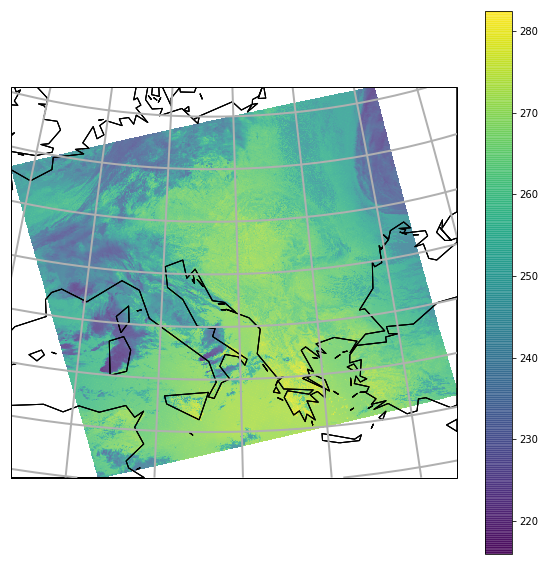

In [11]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(1, 1, figsize=(10,10),
                          subplot_kw={'projection': crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
ax.set_extent(crs.bounds,crs)
cs=ax.imshow(image_30, transform=crs, extent=crs.bounds, origin='upper',alpha=0.8)
fig.colorbar(cs);